In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn import preprocessing
import sklearn.metrics as metrics
from sklearn import linear_model
from torch import nn
import torch



In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

In [3]:
def preprocess(df):
    # df = df.dropna()
    # df = df[df["Crop"]=="Avocados"]
    # df = df.drop(columns="Crop", axis=1)
    # df = df.drop(columns="Year", axis=1)
    df['Export Quantity'] = df['Export Quantity'].interpolate(method='linear', limit_direction='backward', axis=0)
    scaler = preprocessing.StandardScaler()
    scal_feat = ['Temperature (Avg)','Precipitation','Export Quantity','Fertilizer Usage']
    df[scal_feat]=scaler.fit_transform(df[scal_feat].to_numpy())
    feat = scal_feat + ["Crop"]
    X = df[feat].copy(deep=True)
    X = pd.get_dummies(X, columns = ['Crop'])
    y = df['Yield'].copy(deep=True)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 13)

    return X_train, X_test, y_train, y_test, X
    

In [5]:
def compute_scores(y_test, y_pred):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse) 
    r2 = metrics.r2_score(y_test, y_pred)
    print("MAE : ",mae)
    print("MSE : ",mse)
    print("RMSE : ",rmse)
    print("R2 : ",r2)

In [4]:
df = pd.read_csv("Data/crop_yield_data.csv")

In [6]:
X_train, X_test, y_train, y_test, X = preprocess(df)

#### Linear Regression

In [15]:
model_lin = LinearRegression()
model_lin.fit(X_train, y_train)
y_pred_linear= model_lin.predict(X_test)
compute_scores(y_test, y_pred_linear)

MAE :  14735.196362244102
MSE :  413785184.80689985
RMSE :  20341.710469055935
R2 :  0.8316633489066173


#### Decision Tree

In [16]:
dt_regression = DecisionTreeRegressor()
dt_regression.fit(X_train, y_train)
y_pred_dt = dt_regression.predict(X_test)
compute_scores(y_test, y_pred_dt)

MAE :  10626.416666666666
MSE :  248188971.79166666
RMSE :  15754.014465896198
R2 :  0.8990314252811727


#### KNN

In [23]:
kNN = KNeighborsRegressor(n_neighbors=10) #tweak number of neighbours
kNN.fit(X_train, y_train)
y_pred_knn = kNN.predict(X_test)
compute_scores(y_test, y_pred_knn)

MAE :  12449.214583333334
MSE :  429741854.4960417
RMSE :  20730.215978036547
R2 :  0.8251718348633416


#### Shrinkage - Ridge

In [19]:
ridge_regression = Ridge(alpha=1.0, solver = 'auto', random_state = 13) #if we use alpha = 0, it becomes simple LR problem, solver = ‘auto’, ‘svd’, ‘cholesky’, ‘lsqr’, ‘sparse_cg’, ‘sag’, ‘saga’, ‘lbfgs’
ridge_regression.fit(X_train, y_train)
y_pred_ridge = ridge_regression.predict(X_test)
compute_scores(y_test, y_pred_ridge)

MAE :  14790.581353713394
MSE :  420434163.38418055
RMSE :  20504.491297864002
R2 :  0.8289584024078358


#### Shrinkage - Lasso

In [20]:
lasso_regression = linear_model.Lasso(alpha=0.1, random_state = 13)
lasso_regression.fit(X_train, y_train)
y_pred_lasso = lasso_regression.predict(X_test)
compute_scores(y_test, y_pred_lasso)

MAE :  14735.211625845215
MSE :  413786300.6856904
RMSE :  20341.737897379622
R2 :  0.8316628949432916


In [7]:
class CropPredictor(nn.Module):
    def __init__(self, input_features, hidden_units) -> None:
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=200),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=200, out_features=200),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=200, out_features=1)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

torch.manual_seed(13)
model_0 = CropPredictor(8,50)
model_0

CropPredictor(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=8, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=200, out_features=1, bias=True)
  )
)

In [8]:
X_train = torch.tensor(X_train[:].values).float()
X_test = torch.tensor(X_test[:].values).float()
y_train = torch.tensor(y_train[:].values).float()
y_test = torch.tensor(y_test[:].values).float()
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

In [9]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.1)

In [10]:
torch.manual_seed(13)

# Set the number of epochs 
epochs = 1000

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training
    model_0.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_0.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_0(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 7240638464.0 | Test loss: 7838788096.0
Epoch: 100 | Train loss: 555583168.0 | Test loss: 400215008.0
Epoch: 200 | Train loss: 627298240.0 | Test loss: 339342496.0
Epoch: 300 | Train loss: 504939680.0 | Test loss: 362146688.0
Epoch: 400 | Train loss: 514248800.0 | Test loss: 402304384.0
Epoch: 500 | Train loss: 591624192.0 | Test loss: 370853088.0
Epoch: 600 | Train loss: 670691008.0 | Test loss: 339937664.0
Epoch: 700 | Train loss: 578790592.0 | Test loss: 379446240.0
Epoch: 800 | Train loss: 625507776.0 | Test loss: 359042080.0
Epoch: 900 | Train loss: 628103744.0 | Test loss: 359672576.0


In [11]:
compute_scores(y_test.reshape(1, len(y_test)).squeeze(), test_pred.reshape(1, len(test_pred)).squeeze())

MAE :  11406.935
MSE :  365213980.0
RMSE :  19110.5725712235
R2 :  0.8514231497000964


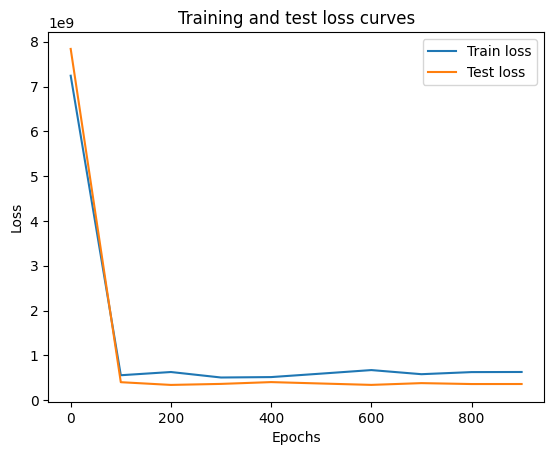

In [12]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();